In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xvf imagenette2-320.tgz


--2025-01-18 19:30:00--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.184.15, 3.5.13.121, 52.216.9.181, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.184.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325,83M  4,08MB/s    in 77s     

2025-01-18 19:31:18 (4,25 MB/s) - ‘imagenette2-320.tgz’ saved [341663724/341663724]

imagenette2-320/
imagenette2-320/train/
imagenette2-320/noisy_imagenette.csv
imagenette2-320/val/
imagenette2-320/val/n03394916/
imagenette2-320/val/n03417042/
imagenette2-320/val/n03445777/
imagenette2-320/val/n02102040/
imagenette2-320/val/n03425413/
imagenette2-320/val/n03888257/
imagenette2-320/val/n03028079/
imagenette2-320/val/n03000684/
imagenette2-320/val/n01440764/
imagenette2-320/val/n02979186/
imagenette2-320/val/n02979186/n029791

## Import

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random



## Load Dataset

In [ ]:
data_dir = 'imagenette2-320'
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    v2.RandomAffine(degrees=(0, 360), translate=(0.0, 0.2), shear=(-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train'),
    transform=train_transforms
)

val_dataset = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'val'),
    transform=val_transforms
)




In [ ]:
# Create data loaders
train_batch_size = 128
val_batch_size = 128

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=val_batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

Number of training images: 9469
Number of validation images: 3925


## Define a Model

In [ ]:

# If you want to load ImageNet-pretrained weights, set pretrained=True
model = models.resnet18(weights=None)

# The output layer of ResNet18 is 'fc' with 1000 outputs by default.
# Imagenette has 10 classes, so we need to change it.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes in Imagenette

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_loss_history = []
val_loss_history   = []
train_acc_history  = []
val_acc_history    = []

best_val_acc = 0.0

num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()
        optimizer.step()

        # Stats
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = running_corrects.double() / total

    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc.item())

    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels)
            val_total += labels.size(0)

    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc = val_running_corrects.double() / val_total

    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc.item())

    # Update best val accuracy
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"New best model saved! Val Acc: {best_val_acc:.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

print(f"\nBest Val Acc achieved: {best_val_acc:.4f}")

New best model saved! Val Acc: 0.2948
Epoch [1/80] Train Loss: 2.0001 | Train Acc: 0.3111 | Val Loss: 2.0150 | Val Acc: 0.2948
New best model saved! Val Acc: 0.3699
Epoch [2/80] Train Loss: 1.7961 | Train Acc: 0.3839 | Val Loss: 2.0062 | Val Acc: 0.3699
New best model saved! Val Acc: 0.4344
Epoch [3/80] Train Loss: 1.7093 | Train Acc: 0.4204 | Val Loss: 1.7356 | Val Acc: 0.4344
New best model saved! Val Acc: 0.4586
Epoch [4/80] Train Loss: 1.6230 | Train Acc: 0.4556 | Val Loss: 1.6244 | Val Acc: 0.4586
New best model saved! Val Acc: 0.4634
Epoch [5/80] Train Loss: 1.5796 | Train Acc: 0.4678 | Val Loss: 1.5795 | Val Acc: 0.4634
New best model saved! Val Acc: 0.4978
Epoch [6/80] Train Loss: 1.5460 | Train Acc: 0.4860 | Val Loss: 1.4831 | Val Acc: 0.4978
Epoch [7/80] Train Loss: 1.4913 | Train Acc: 0.5048 | Val Loss: 1.7544 | Val Acc: 0.4848
New best model saved! Val Acc: 0.5027
Epoch [8/80] Train Loss: 1.4481 | Train Acc: 0.5126 | Val Loss: 1.5457 | Val Acc: 0.5027
Epoch [9/80] Train Los

## Plotting Loss and Accuracy

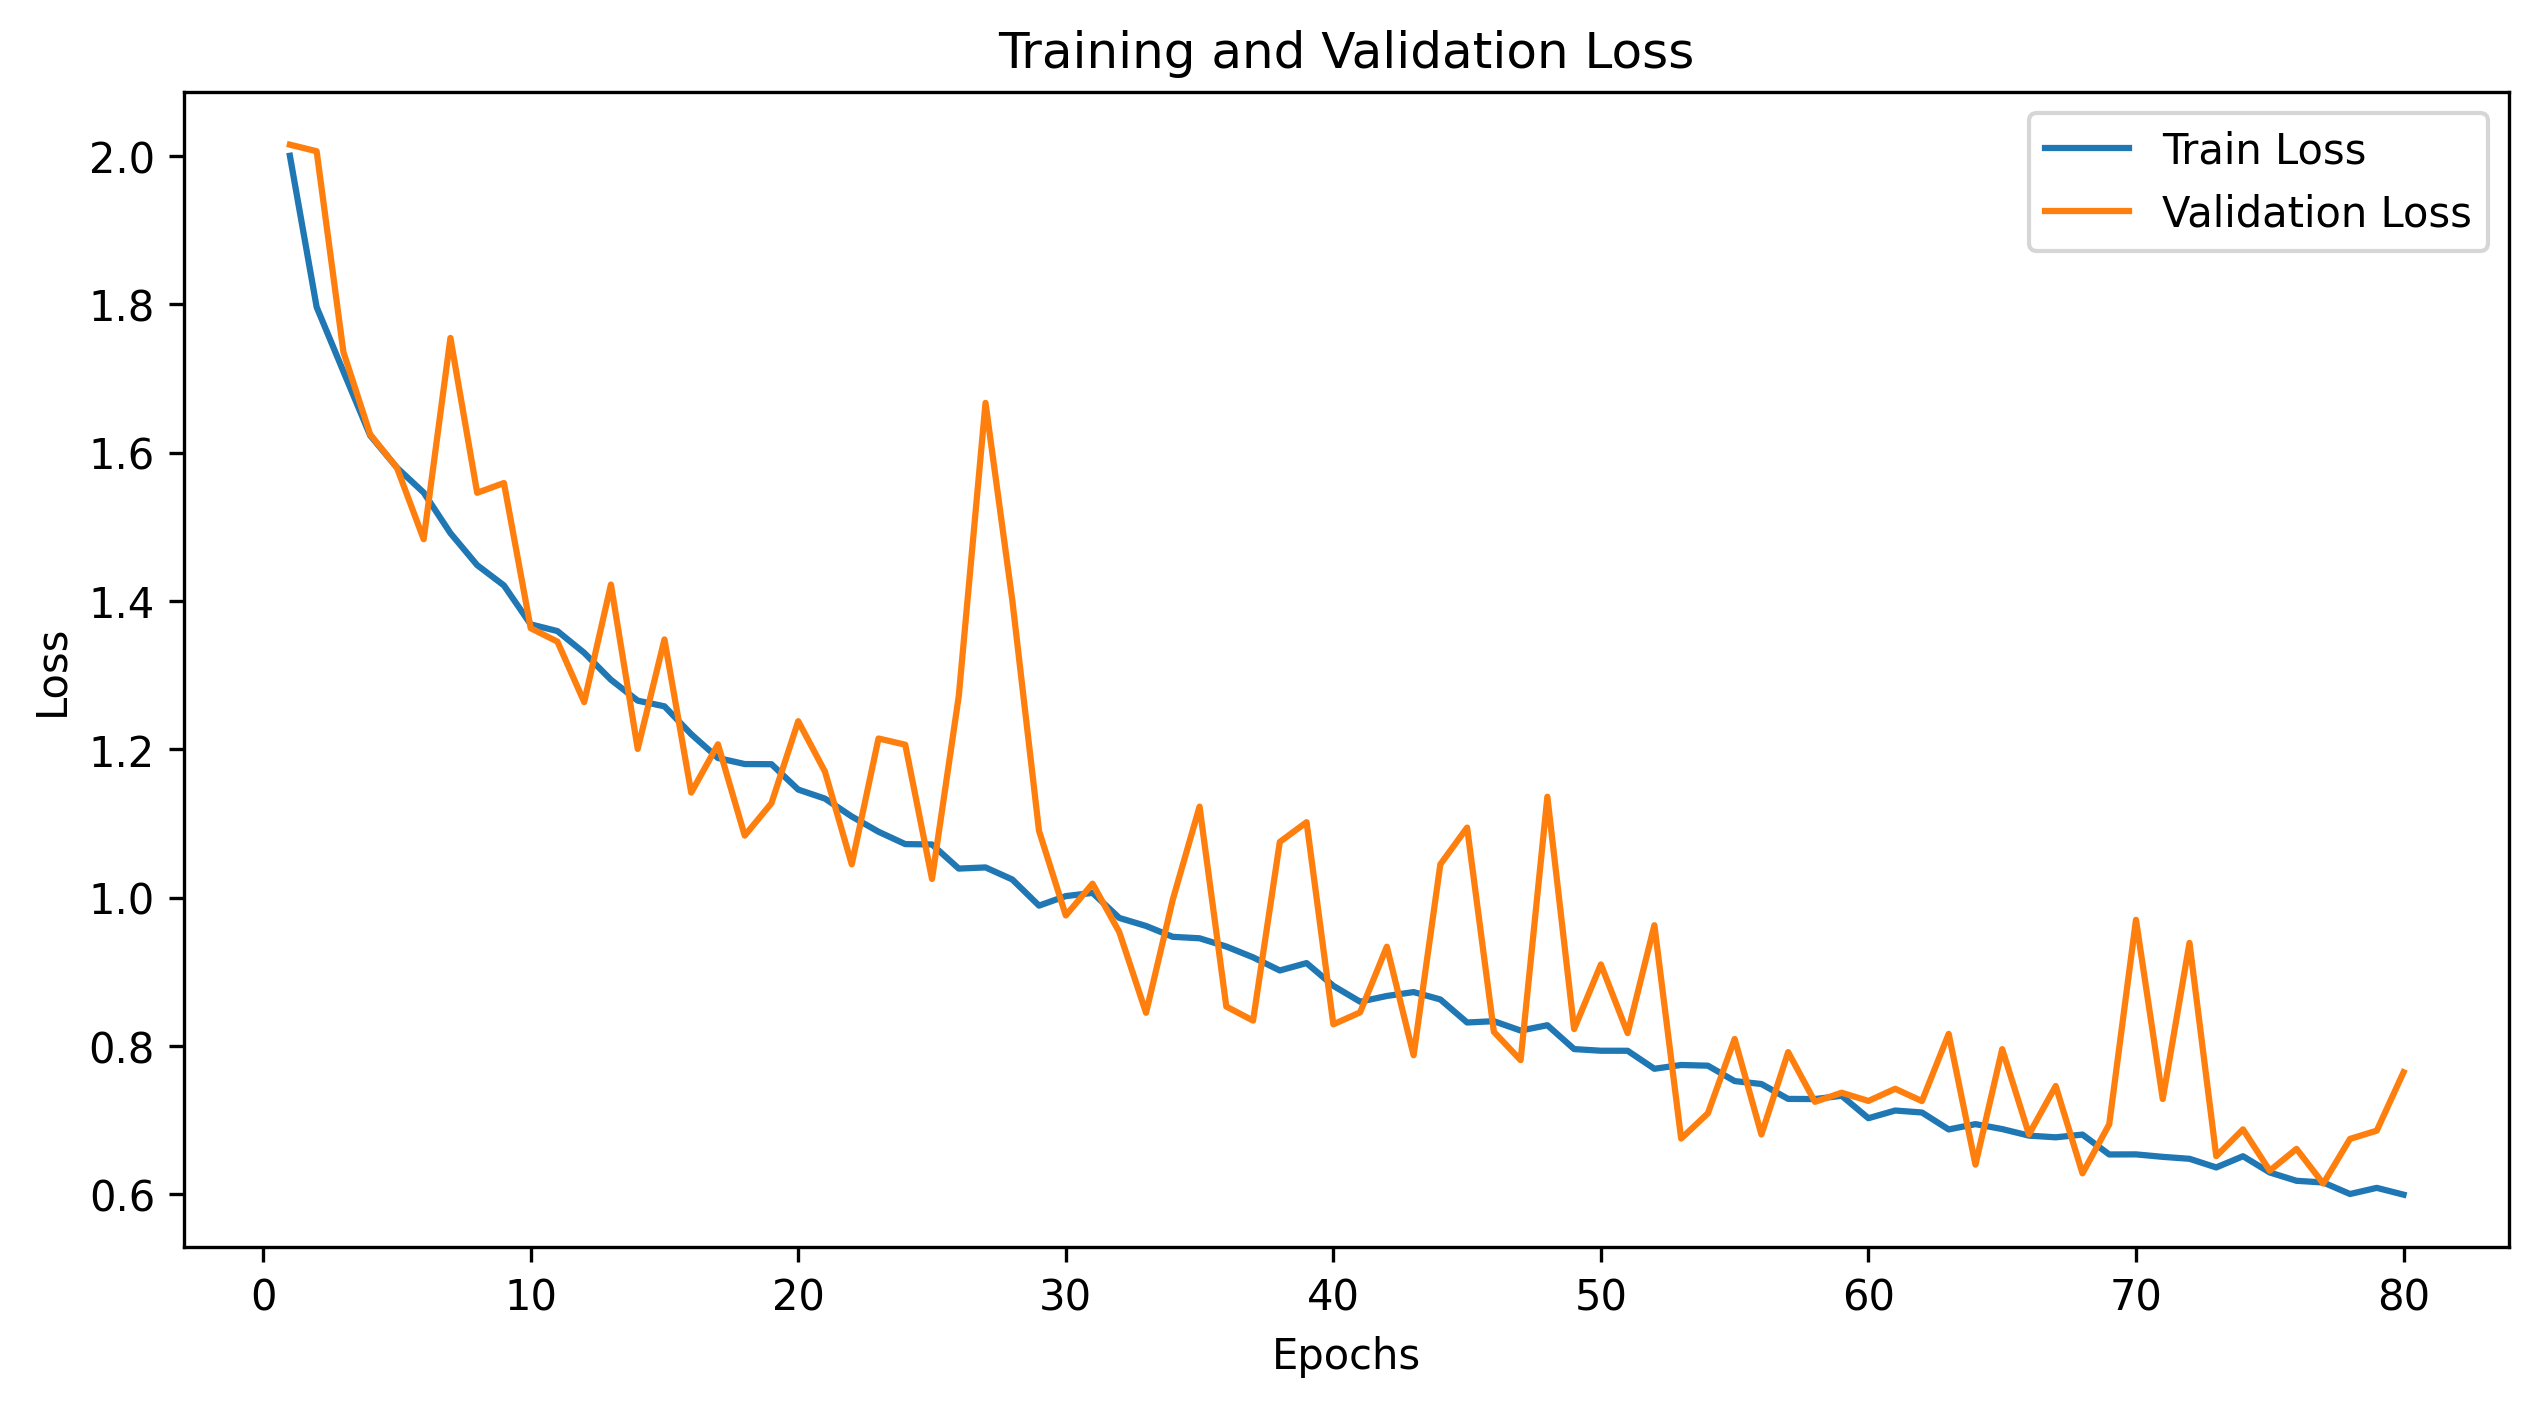

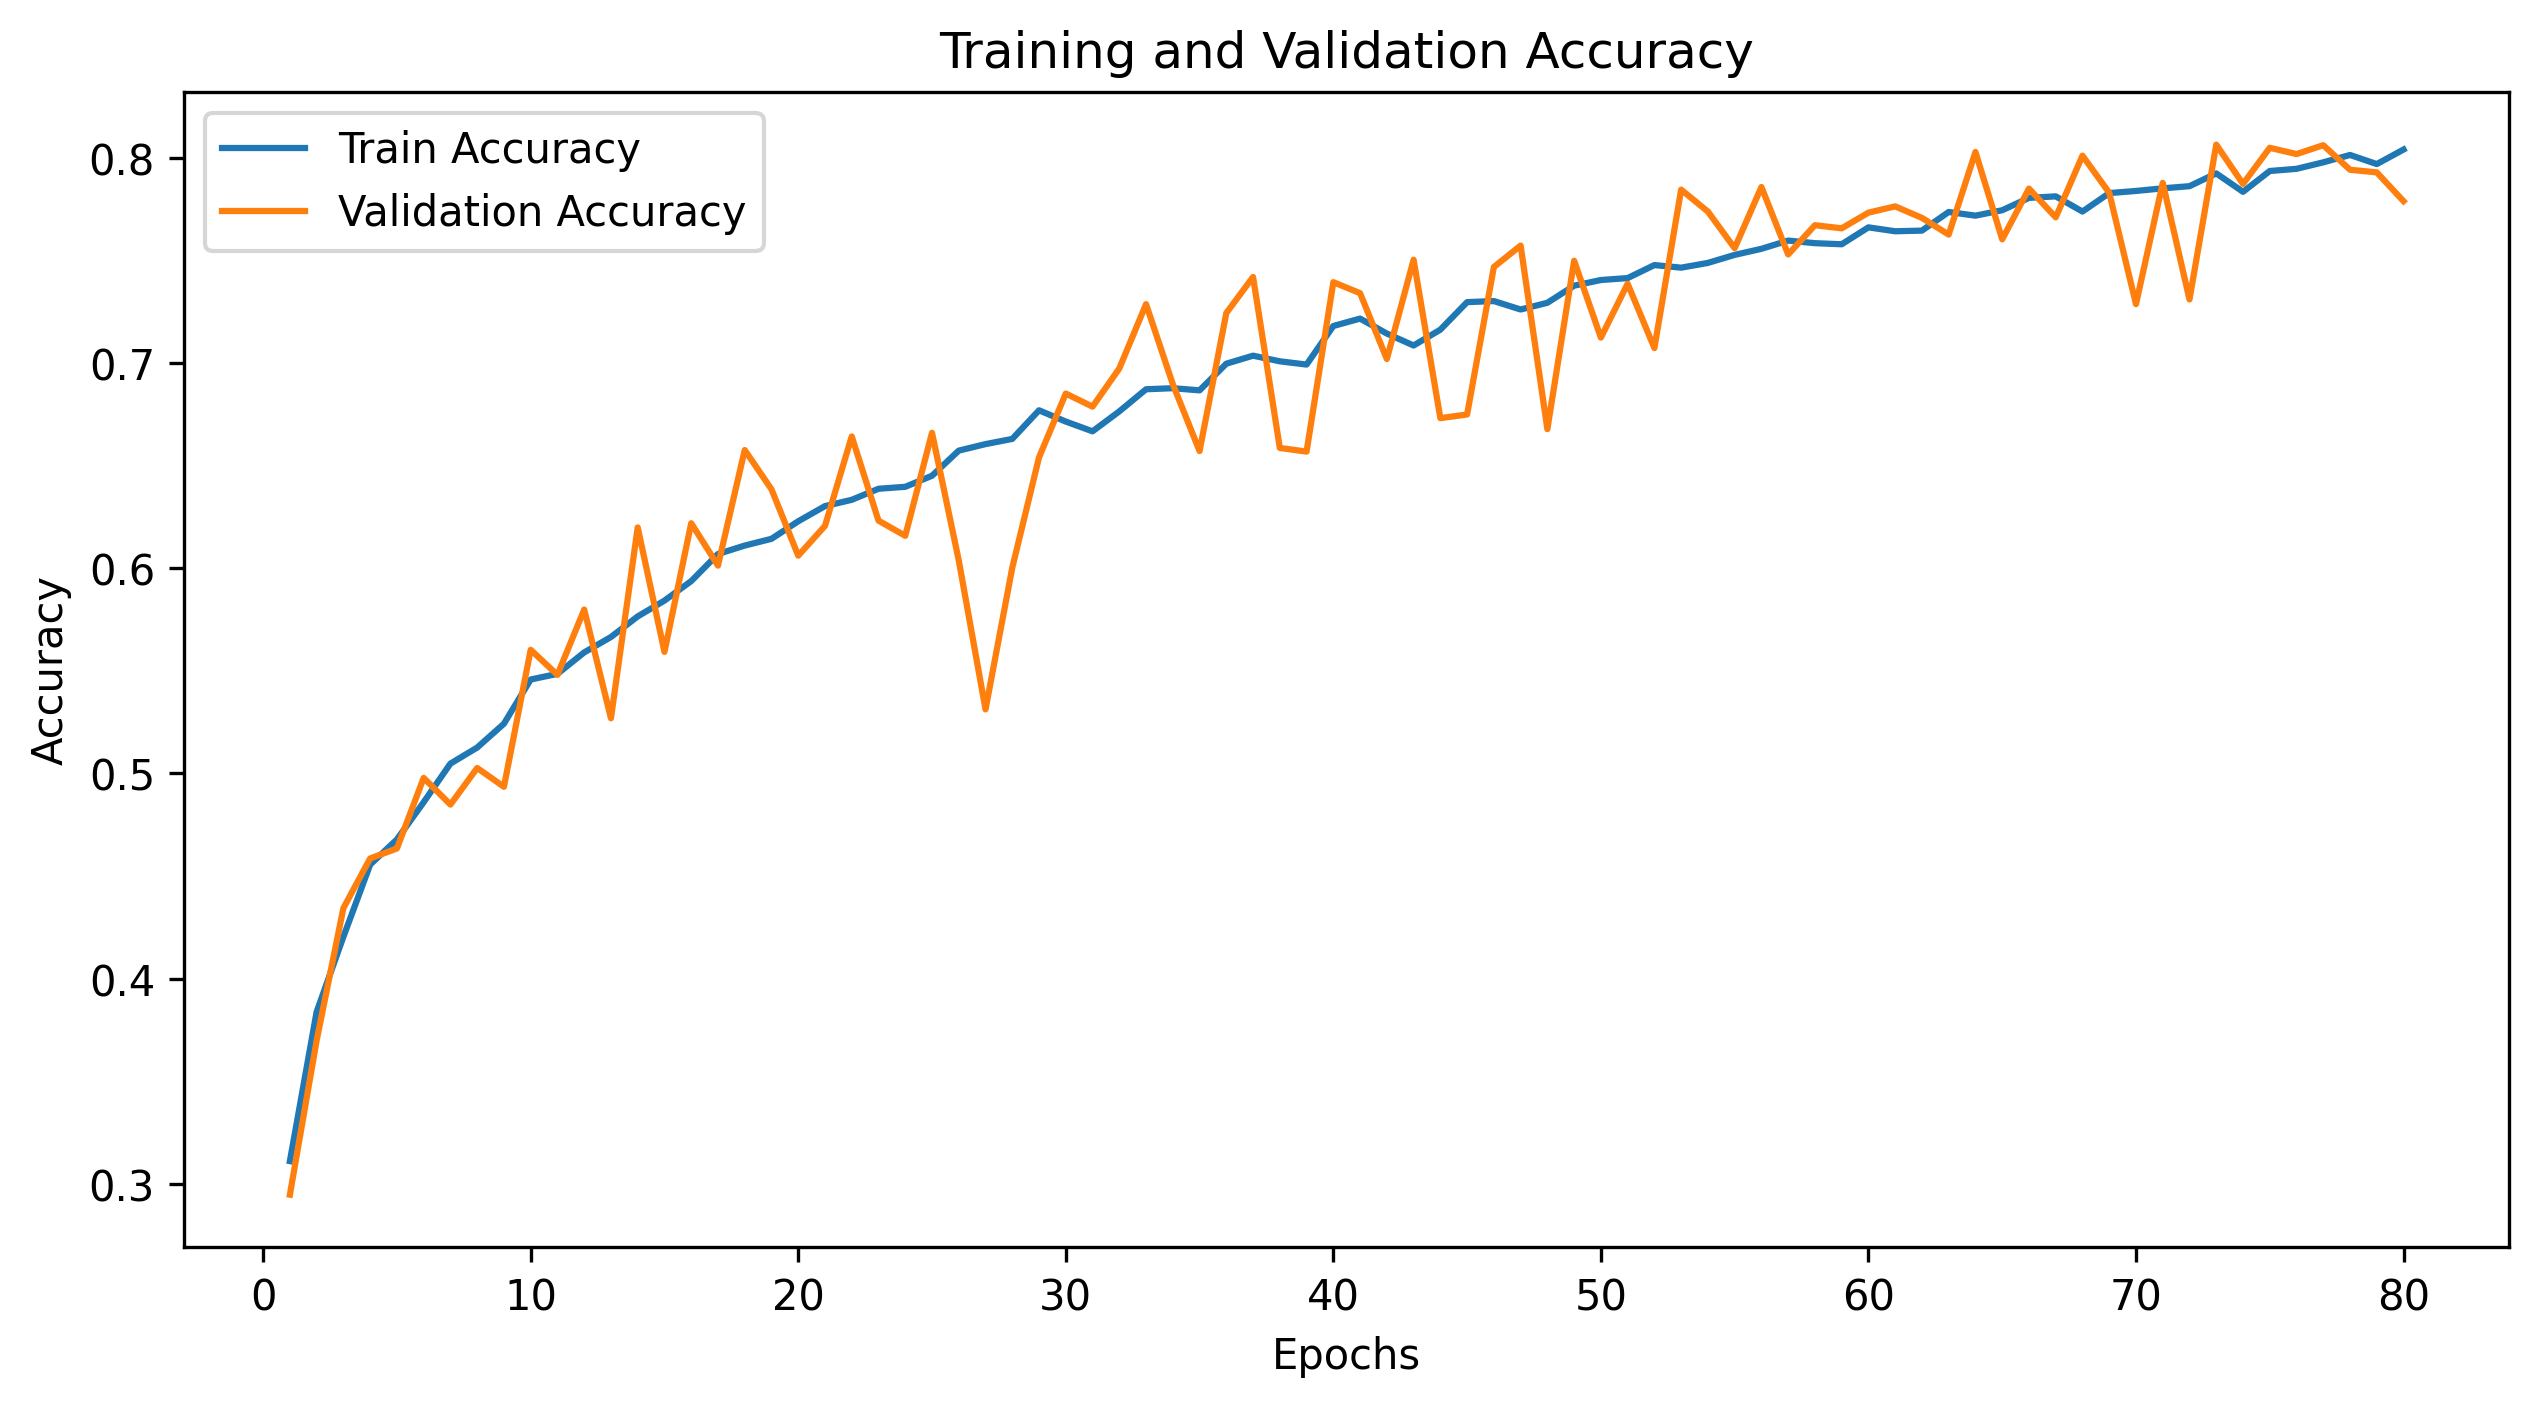

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss_history, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()
